# Restaurant Recommender System

**Authors**: Lyla Kiratiwudhikul, Mina Lee, Tom Zhang

**Table of Contents**:

1. Motivations and Objectives
2. Data Overview and Preprocessing
3. Exploratory Data Analysis
4. Modeling
    - Baseline Model
    - Neural Collaborative Filtering (NCF) Model

In [1]:
from pprint import pprint
from datetime import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from surprise import Dataset, Reader, KNNWithMeans  # pip install scikit-surprise
from surprise.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.optimizers import Adam

from textblob import TextBlob  # pip install textblob

np.random.seed(209)
t0 = datetime.now()

## Motivations and Objectives

For the past few decades, with the fast growing market of digital platforms, 
companies have tried to customize the advertising of their products based on individual customers' preferences or interests. 
This practice has been utilized across various industries and companies, from the e-commerce site Amazon suggesting relevant products to the streaming platform Netflix recommending similar shows to their users' view history and profile. The recommendation systems help increase sales as the users are able to easily see and purchase recommended products that match their needs and preferences.

In this project, we focus on devising a restaurant recommendation system (hereby referred to as “recommender”).
We use data of restaurants and customer profiles from Yelp, a platform for crowd-sourced reviews about businesses.
As an individual has unique restaurant preferences, such as cuisines, ambience, pets, diet types, and/or parking availability, we aim to build the recommender to recommend restaurants to users based on the insights gleaned from their reviews on the previous restaurants they have been to.

## Data Overview

The data is downloaded from [Yelp official website](https://www.yelp.com/dataset/documentation/main). There are three datasets relevant to our analysis and models: `business`, `review`, and `user` data. The `business` dataset contains information about the businesses including name, location, hours, average rating stars, hours, number of reviews, and other features such as cuisine types and parking availability. The `user` data include the user's friend mapping and all the metadata associated with the user such as number of upvotes. The `review` dataset records full review text data as well as the `user_id` who wrote the review and the `business_id` for which the review was written. There are 150,346 businesses and 6,990,280 reviews in the Yelp original datasets. Below is the list of features in the two raw datasets:

**Business:**
- `business_id`: business’s ID, string
- `name`: business’s name, string
- `address`: business’s full address, string
- `city`: business’s city, string
- `state`: business’s state, string, 2 character state code, if applicable
- `postal_code`: business’s postal code, string
- `latitude`: business’s latitude, float
- `longitude`: business’s longitude, float
- `stars`: business’s average stars rating, float (ranging from 1 to 5, with 0.5 increment)
- `review_count`: business’s number of reviews, integer
- `is_open`	: whether the business is open or closed; 0 or 1 for closed or open, integer
- `attributes`: business’s features (e.g whether it offers parking, whether it accept credit cards, etc), JSON object
- `categories`: business’s categories (e.g. “Mexican”, “Burger”, etc), array of strings
- `hours`: business’s working hours, object of key day (Monday-Sunday) to value hours

**Review:**
- `review_id`: unique review ID, string
- `user_id`: 22 character user’s ID, string
- `business_id`: 22 character business’s ID, string
- `stars`: business’s stars rating, integer (1 to 5)
- `useful`: number of useful votes received, integer
- `integer`: number of funny votes received, integer
- `cool`: number of cool votes received, integer	
- `text`: review itself, string
- `date`: date format YYYY-MM-DD, string

**User:**
- `user_id`: 22 character user’s ID, string
- `name`: user's first name, string 
- `review_count`: number of reviews they've written, int  
- `yelping_since`: date the user joined Yelp, string in format YYYY-MM-DD
- `useful`: number of useful votes sent by the user, int 
- `funny`: number of funny votes sent by the user, int 
- `cool`: number of cool votes sent by the user, int 
- `elite`: the years the user was elite, array of integers, 
- `friends`: an array of the user's friend as user_ids, array of strings 
- `fans`: number of fans the user has, int 
- `average_stars`: average rating of all reviews, float
- `compliment_hot`: number of hot compliments received by the user, int
- `compliment_more`: number of more compliments received by the user, int  
- `compliment_profile`: number of profile compliments received by the user, int 
- `compliment_cute`: number of cute compliments received by the user, int
- `compliment_list`: number of list compliments received by the user, int
- `compliment_note`: number of note compliments received by the user, int
- `compliment_plain`: number of plain compliments received by the user, int
- `compliment_cool`: number of cool compliments received by the user, int
- `compliment_funny`: number of funny compliments received by the user, int 
- `compliment_writer`: number of writer compliments received by the user, int
- `compliment_photos`: number of photo compliments received by the user, int

### Data Preparation

**Business:**

As the main goal of this project is to build a recommender system that suggests top restaurants and their offerings based on user location, we have excluded the entries that are not classified as restaurants such as “spas”, “hotels”, and “hair salons” by dropping all rows whose `categories` do not contain any of the following keywords: “food”, “restaurant”, “bar”, “pubs”, “restaurant”, “tea”, and “coffee”. This has decreased the number of entries from 150,346 to 69,253.

Further, we have expanded `attributes` columns based on the JSON objects given. The first attempt returned 39 new columns. However, some of the expanded features contained nested JSON objects, so we further expanded `BusinessParking`, `Ambience`, `DietaryRestrictons`, and `Music` features and concatenated them to the other attributes, resulting in final 62 columns.

In addition, the missing values in original and newly created attributes based features are filled with `None`, indicating that the information is not available. We decided to impute the missing values this way instead of mode imputation method because there are users who might be indifferent regarding the missing attributes and those who are concerned about them (e.g. whether there is parking or not).

For `hours`, an expansion of operating hour objects into seven days was performed first. For the 9,710 missing entries for hours, we imputed the operating hours with the modes of the dataset for businesses whose value for the hours column was completely missing and imputed with `"closed"` for businesses whose hours are available for only some days and are not provided for the other days (i.e. we assumed that these restaurants are closed on the missing days).

Furthermore, there are a few states that have only one business in our dataset, which are not suitable for our recommender task, and we have, thus, decided to drop these states with only one business: North Carolina, Colorado, Hawaii, Montana, and South Dakota.

The final dataset for the business records has a total of 84 features with 68,054 entries. The business dataset has a total of five numeric features (`latitude`, `longitude`, `stars`, `review_count`, `is_open`). However, since `is_open` is a binary feature and `latitude` and `longitude` are useful in their original states. Only `stars` and `review_count` have been standardized to prevent any potential bias from large scales.


**Review:**

For the review dataset, we have first filtered the dataset in accordance with the business dataset by filtering out reviews for irrelevant businesses (using `business_id`) that have been pre-processed out as described above. This has reduced the size of the review dataset from 6,990,280 to 5,257,329 entries. Since the review dataset do not have missing entries, no imputation or dropping related to missing values have been conducted. However, we have decided to standardize the numeric features (`stars`, `useful`, `funny`, `cool`) in the review dataset to prevent any larger scales dominating the analysis and leading to a biased result.


**User:**

For the user dataset, we first filtered the dataset by keeping only the reviewers that exist in the already processed review data as described previously. Note that there is no missing values in this dataset. We also performed feature simplication and engineering: The features `elite` and `friends` are lists of values. In the context of building our recommender system task, the specific values do not matter much, so we aggretated the two variables by transforming them into counts. Aggregating instead of splitting can also potentially reduce overfitting. We also converted `yelping_since` into `membership_days` to represent how long a user has been a member. We used `March 28,2023` as the baseline for "today". In addition, we standardized all the numeric features as preparation for our model.

Note: the code for data preparation can be found in `business_dat_inspect.ipynb`, `review_data_inspect.ipynb`, and `user_data_inspect.ipynb`.

## Exploratory Data Analysis

After cleaning the business data as described above, there are 68,054 restaurant-type businesses and 5,257,329 user reviews left in the datasets. Figure 1 shows that the restaurants in the dataset are located in 12 states with over 23% of them in Pennsylvania.

<figure>
<figcaption><strong>Figure 1</strong></figcaption>
<img src="Figures/map_numrecords_by_state.png"  width="700">
</figure>

The average star (a rating ranging from 1 to 5 with 0.5 increment) of these restaurants is approximately 3.6 with around 75 reviews for each restaurant. 

In [2]:
busi_df = pd.read_feather("data/yelp_business_cleaned.feather")
print(f"There are {busi_df.shape[0]} business records with {busi_df.shape[1]} total features.")
display(busi_df.head(3))
busi_df[['stars', 'review_count']].describe()

There are 68054 business records with 84 total features.


,original_index,business_id,name,address,city,state,postal_code,latitude,longitude,stars,...,music_live,music_video,music_karaoke,hours_Monday,hours_Tuesday,hours_Wednesday,hours_Thursday,hours_Friday,hours_Saturday,hours_Sunday
0,3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,...,None,None,None,7:0-20:0,7:0-20:0,7:0-20:0,7:0-20:0,7:0-21:0,7:0-21:0,7:0-21:0
1,4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,...,None,None,None,closed,closed,14:0-22:0,16:0-22:0,12:0-22:0,12:0-22:0,12:0-18:0
2,5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,...,None,None,None,0:0-0:0,6:0-22:0,6:0-22:0,6:0-22:0,9:0-0:0,9:0-22:0,8:0-22:0


,stars,review_count
count,68054.000000,68054.000000
mean,3.563949,74.619861
std,0.851437,169.900997
min,1.000000,5.000000
25%,3.000000,11.000000
50%,3.500000,27.000000
75%,4.000000,73.000000
max,5.000000,7568.000000


When looking at the distribution of rating stars, it is slightly left skewed with mode at $4.0$. On the other hand, the highly right skewed distribution of the number of reviews shown below indicates that a small number of restaurants are more popular than the others and have more reviews. Most users tend to rate restaurants between 3.0 and 4.5. Only a small fraction of them give out 1 star.

Text(0, 0.5, 'Number of restaurants')

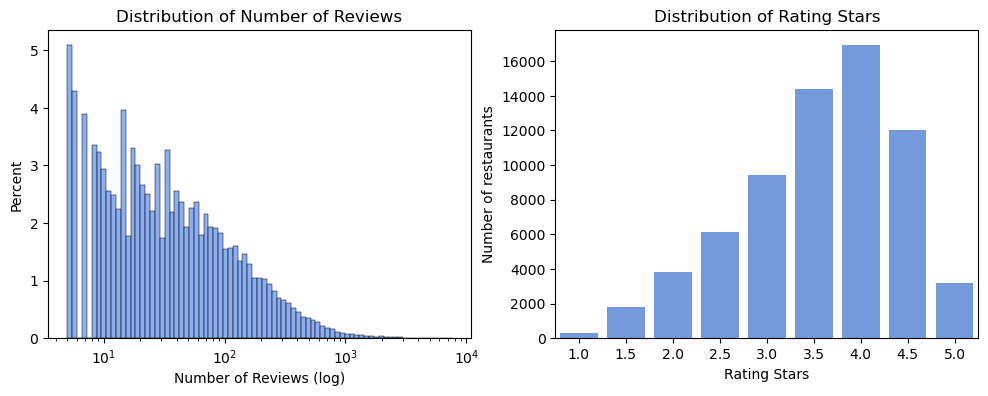

In [3]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
sns.histplot(data = busi_df, x = 'review_count', 
             color = 'cornflowerblue', stat = 'percent',
             log_scale = True, ax = ax[0])
ax[0].set_title("Distribution of Number of Reviews")
ax[0].set_xlabel("Number of Reviews (log)")

sns.barplot(data = busi_df.groupby(['stars'])[['business_id']].agg('count').reset_index().astype({'stars': str}),
            x = 'stars', 
            y = 'business_id',
            color = 'cornflowerblue', ax = ax[1])
ax[1].set_title("Distribution of Rating Stars")
ax[1].set_xlabel("Rating Stars")
ax[1].set_ylabel("Number of restaurants")

Still, not all of the restaurants in the dataset are still in operation. About 30% of the businesses have been closed. This fact has an important implication for our recommender system. We may use data from restaurants that are now closed during training to gain more insights into what users like and dislike. However, we will not recommend users to a closed restaurant. 

Text(0, 0.5, 'Percentage (%)')

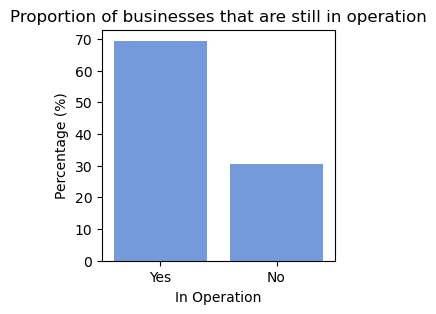

In [4]:
# proportion of businesses that are still in operation
in_oper = busi_df['is_open'].value_counts(normalize = True, sort = True, dropna = False)
in_oper = in_oper.to_frame().reset_index()
in_oper.rename(columns = {'is_open': 'proportion', 'index' : 'in operation'}, inplace = True)
in_oper['in operation'] = in_oper['in operation'].map({1: "Yes", 0: "No"})
in_oper['proportion'] = in_oper['proportion'] * 100

fig, ax = plt.subplots(figsize = (3, 3))
sns.barplot(data = in_oper,
            x = 'in operation', y = "proportion", 
            order = ['Yes', 'No'],
            color = "cornflowerblue")
plt.title("Proportion of businesses that are still in operation")
plt.xlabel("In Operation")
plt.ylabel("Percentage (%)")

The following describes some characteristics of the restaurants in the dataset that users might weigh when choosing a restaurant and hence might be a critical aspect for our recommender system: 
- More than half of the restaurants price their services below $30 and there are a small number of high-end restaurants (pricing over $61).
- In addition, for customers who have cars, over 60 percent of the restaurants indicate that they have at least one parking option (e.g. on street, parking lots, valet, etc.). 
- We believe that certain users have dietary restrictions and so we look at the special diet types that restaurants offer. The data shows that more than $99\%$ of restaurants do not indicate their dietary accommodations on Yelp. Yet, for those whom we do have data, gluten-free, vegetarian, and vegan are the top 3 most available options. 
- There are only about $5\%$ of restaurants that are dog-friendly. This feature might be important for dog owners who want to eat out and bring their dogs with them. 

Regardless, we must use these characteristics with caution as the information for the majority of businesses on our dataset is not available.


Text(0, 0.5, 'Percentage (%)')

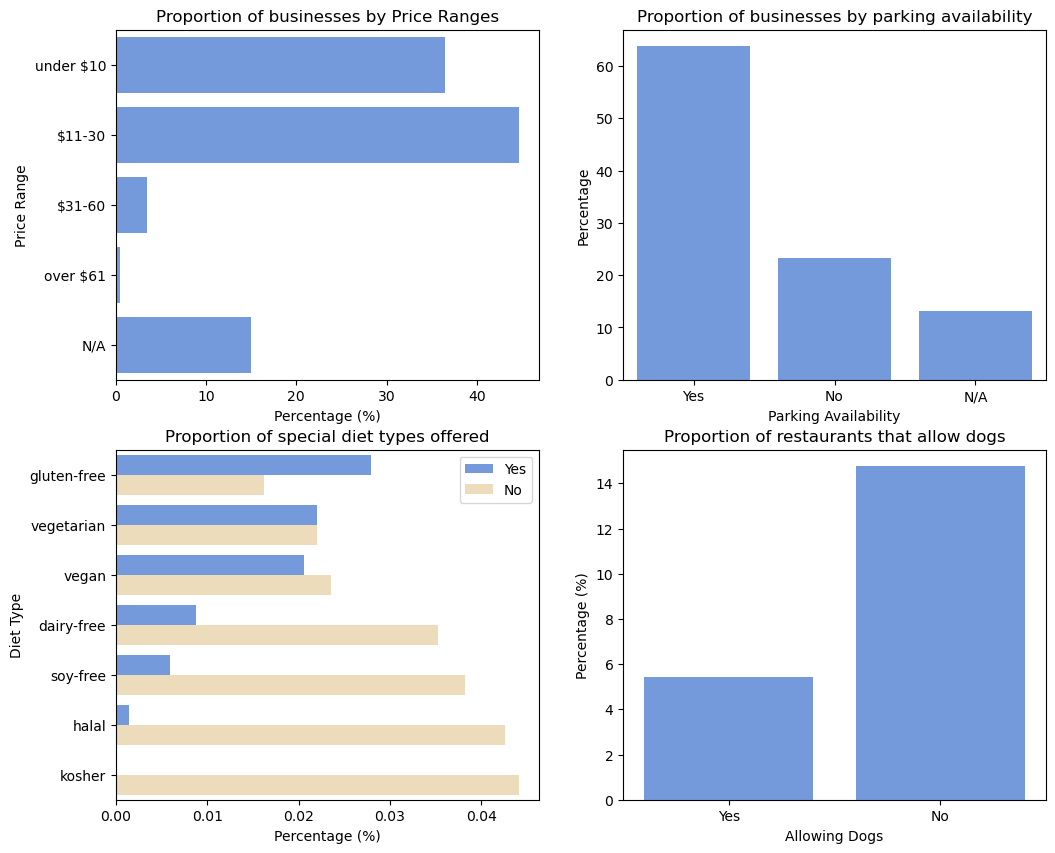

In [5]:
### Price ranges
label_map = {"1": "under $10",
             "2": "$11-30",
             "3": "$31-60",
             "4": "over $61",
             "None": "N/A"}
priceranges = busi_df['RestaurantsPriceRange2'].map(label_map).value_counts(normalize = True, sort = True, dropna = False)
priceranges = priceranges.to_frame().reset_index()
priceranges.rename(columns = {'RestaurantsPriceRange2': 'proportion', 'index' : 'price range'}, inplace = True)
priceranges['proportion'] = priceranges['proportion'] * 100
# priceranges

busi_df['has_parking'] = busi_df[['parking_garage', 'parking_street', 
                        'parking_validated', 'parking_lot', 
                        'parking_valet']].replace({"None": np.nan,
                                                "True": 1, 
                                                "False": 0}).max(axis = 1)
parking_stat = busi_df['has_parking'].value_counts(dropna = False, normalize = True).to_frame().reset_index()
parking_stat.rename(columns = {'has_parking': 'proportion', 'index' : 'has_parking'}, inplace = True)
parking_stat['has_parking'] = parking_stat['has_parking'].map({1: "Yes", 0: "No"})
parking_stat['has_parking'].fillna("N/A", inplace = True)
parking_stat['proportion'] = parking_stat['proportion'] * 100
# parking_stat

diets = busi_df[['diet_dairy-free', 'diet_gluten-free',
                'diet_vegan', 'diet_kosher',
                'diet_halal', 'diet_soy-free',
                'diet_vegetarian']].replace({"None": np.nan,
                                        "True": 1, 
                                        "False": 0})
val_count_list = []
for d in list(diets.columns):
    count = diets[d].value_counts(dropna = False, normalize = True).to_frame()
    val_count_list.append(count)
diets_counts = pd.concat(val_count_list, axis = 1)
diets_counts.reset_index(inplace = True)
diets_counts['index'] = diets_counts['index'].map({1: "Yes", 0: "No"})
diets_counts['index'].fillna("N/A", inplace = True)
diets_counts = diets_counts.melt(id_vars = ['index'], 
                                 var_name = "diet type",
                                 value_name = 'proportion'
                                 )
diets_counts = diets_counts[diets_counts['index'] != "N/A"]
diets_counts['proportion'] = diets_counts['proportion'] * 100
diets_counts['diet type'] = diets_counts['diet type'].str.replace("diet_", "")
diets_counts.sort_values(["index", "proportion"], ascending = [False, False], inplace = True)
# diets_counts

dog_allow = busi_df['DogsAllowed'].value_counts(normalize = True, sort = True, dropna = False)
dog_allow = dog_allow.to_frame().reset_index()
dog_allow.rename(columns = {'DogsAllowed': 'proportion', 'index' : 'Allowing dogs'}, inplace = True)
dog_allow['Allowing dogs'] = dog_allow['Allowing dogs'].map({"True": "Yes", "False": "No", "None": "N/A"})
dog_allow['proportion'] = dog_allow['proportion'] * 100
# dog_allow


fig, ax = plt.subplots(2, 2, figsize = (12, 10))
ax = ax.ravel()
sns.barplot(data = priceranges,
            y = 'price range', x = "proportion", 
            order = ["under $10", "$11-30", "$31-60", "over $61", "N/A"],
            color = "cornflowerblue", ax = ax[0])
ax[0].set_title("Proportion of businesses by Price Ranges")
ax[0].set_ylabel("Price Range")
ax[0].set_xlabel("Percentage (%)")

sns.barplot(data = parking_stat,
            x = 'has_parking', y = "proportion",
            color = "cornflowerblue", ax = ax[1])
ax[1].set_title("Proportion of businesses by parking availability")
ax[1].set_xlabel("Parking Availability")
ax[1].set_ylabel("Percentage")

sns.barplot(data = diets_counts,
            x = 'proportion', y = "diet type",
            hue = 'index',
            palette = ["cornflowerblue", "wheat"], ax = ax[2])
ax[2].set_title("Proportion of special diet types offered")
ax[2].set_xlabel("Percentage (%)")
ax[2].set_ylabel("Diet Type")
ax[2].legend(title = "")

sns.barplot(data = dog_allow[dog_allow['Allowing dogs'] != "N/A"],
            x = 'Allowing dogs', y = "proportion", 
            order = ['Yes', 'No'],
            color = "cornflowerblue", ax = ax[3])
ax[3].set_title("Proportion of restaurants that allow dogs")
ax[3].set_xlabel("Allowing Dogs")
ax[3].set_ylabel("Percentage (%)")

As for the 5,257,329 user review data, the average of all standardized numeric variables (`stars`, `useful`,`funny`,`cool`) are all close to 0. The only numerical distinction between these features are that they have distinct minimum and maximum values. This might be due to the overall distribution of each numerical value being extremely right skewed, meaning that only a few reviews have received high numbers of useful, funny, and cool votes from other users. 

In [6]:
df_re = pd.read_feather("data/yelp_review_cleaned.feather")
print(f"There are {df_re.shape[0]} review records with {df_re.shape[1]} total features.")
display(df_re.head(3))
df_re[['stars', 'useful','funny','cool']].describe()

There are 5257329 review records with 9 total features.


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
2,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03


,stars,useful,funny,cool
count,5.257329e+06,5.257329e+06,5.257329e+06,5.257329e+06
mean,3.804201e+00,1.021837e+00,3.186590e-01,5.057937e-01
std,1.393488e+00,2.792205e+00,1.728878e+00,2.204489e+00
min,1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
25%,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,5.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
max,5.000000e+00,4.200000e+02,7.920000e+02,4.040000e+02


In [7]:
mean_stars = df_re["stars"].mean() 
mean_useful = df_re["useful"].mean()
mean_funny = df_re['funny'].mean()
mean_cool = df_re['cool'].mean()

min_stars = df_re['stars'].min()
min_useful = df_re['useful'].min()
min_funny = df_re['funny'].min()
min_cool = df_re['cool'].min()

max_stars = df_re['stars'].max()
max_useful = df_re['useful'].max()
max_funny = df_re['funny'].max()
max_cool = df_re['cool'].max()

print(
    "\n"
    f"The mean stars is {mean_stars:.4f} \n"
    f"The mean number of useful is {mean_useful:.4f} \n"
    f"The mean number of funny is {mean_funny:.4f} \n"
    f"The mean number of cool is {mean_cool:.4f} \n"
    f"The minimum and maximum values of stars is {min_stars:.4f} and {max_stars:.4f}\n"
    f"The minimum and maximum values of useful is {min_useful:.4f} and {max_useful:.4f}\n"
    f"The minimum and maximum values of funny is {min_funny:.4f} and {max_funny:.4f}\n"
    f"The minimum and maximum values of cool is {min_cool:.4f} and {max_cool:.4f}"
)


The mean stars is 3.8042 
The mean number of useful is 1.0218 
The mean number of funny is 0.3187 
The mean number of cool is 0.5058 
The minimum and maximum values of stars is 1.0000 and 5.0000
The minimum and maximum values of useful is -1.0000 and 420.0000
The minimum and maximum values of funny is -1.0000 and 792.0000
The minimum and maximum values of cool is -1.0000 and 404.0000


Since `useful`, `funny`, `cool` features represent number of designated votes, we may notice that these numeric are correlated. From the correlation plot, `useful` and `cool` seem to be more correlated than other features and `stars` have little correlations with three other variables.

/var/folders/df/y6mck5f93m5_f04v7_qhxmp40000gn/T/ipykernel_75473/4131803778.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = df_re.corr()


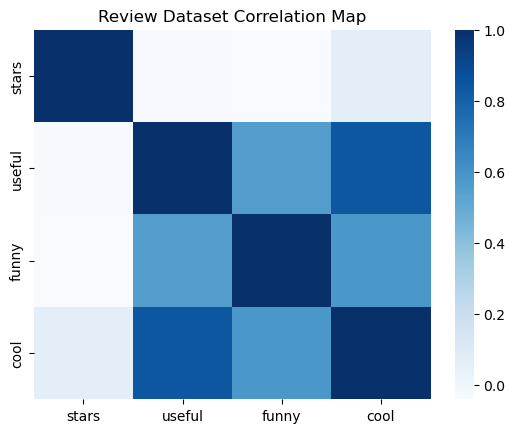

In [8]:
cor = df_re.corr()
sns.heatmap(cor, cmap = 'Blues')
plt.title("Review Dataset Correlation Map")
plt.show()

Below figures are to check the distribution of reviews by business, users, and states. The figures have been investigated by counting the numbers of reviews by distinct `user_id` and by `state` on corresponding the `business_id` after merging the columns of state, city, name, for the filtered business dataset (i.e. restaurants). By doing this, we can understand that there is an imbalance for the review dataset since some users have written more reviews than other users and some restaurants have received much larger quantities of reviews than others. 

Following information have been obtained from the plots:
* A total of 1,532,233 users have written the 5,257,329 reviews on businesses in the dataset. 
* There are 76,869 users who have written more than 10 reviews on businesses. 
* Pennsylvania has the largest amount of reviews from the users on businesses, whereas Illinois has the smallest amount of reviews among the states we have in the dataset.

#### By business

There are 68054 businesses received reviews.


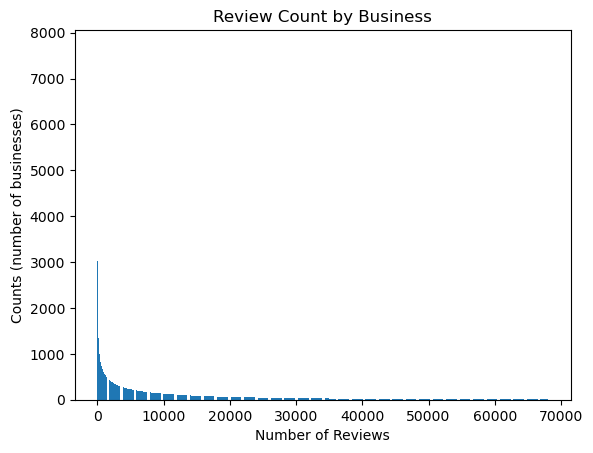

In [9]:
# group by unique business id
review_count_by_business = df_re.groupby('business_id')['review_id'].count().sort_values(ascending=False)
plt.bar(np.arange(review_count_by_business.shape[0]), review_count_by_business);
plt.title('Review Count by Business')
plt.xlabel('Number of Reviews')
plt.ylabel("Counts (number of businesses)")
print(f"There are {len(review_count_by_business)} businesses received reviews.")
plt.show()

#### By states

There are 5257329 review records with 12 total features.


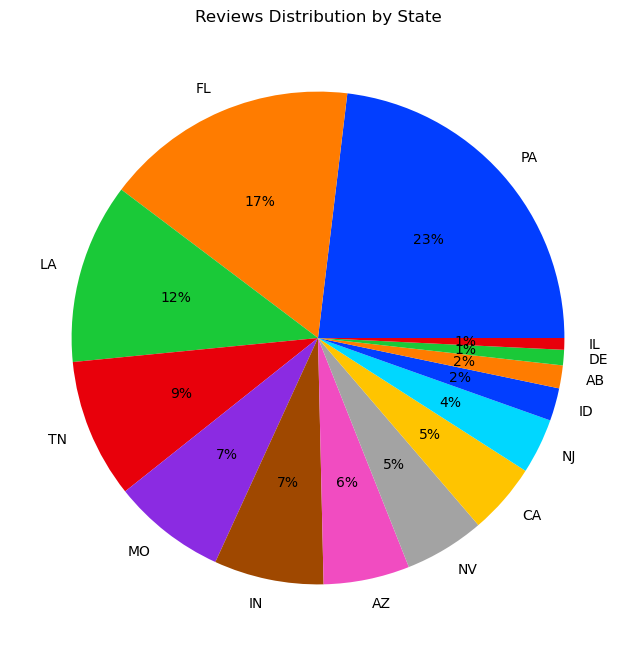

In [10]:
# merge business dataset to get state, city, name
business = pd.read_feather("data/yelp_business_cleaned.feather")
merge = pd.merge(df_re, business, on='business_id', how='outer')
merge = merge[['review_id', 'user_id', 'business_id', 'text', 'date', 'stars_x',
       'useful', 'funny', 'cool','state','city','name']].rename(columns={'stars_x':'stars'})
print(f"There are {merge.shape[0]} review records with {merge.shape[1]} total features.")

# group by state in descending order
state_count_by_business = merge.groupby('state')['business_id'].count().sort_values(ascending=False)

# Pie plot to see the portion as well
plt.figure(figsize=(10,8))
colors = sns.color_palette('bright')[0:14]
plt.pie(state_count_by_business.array, labels=state_count_by_business.index, colors = colors, autopct='%.0f%%')
plt.title("Reviews Distribution by State")
plt.show()

#### By users

1532233 users have written the 5257329 reviews on business in the dataset.
There are 76869 users who have written more than 10 reviews on businesses.


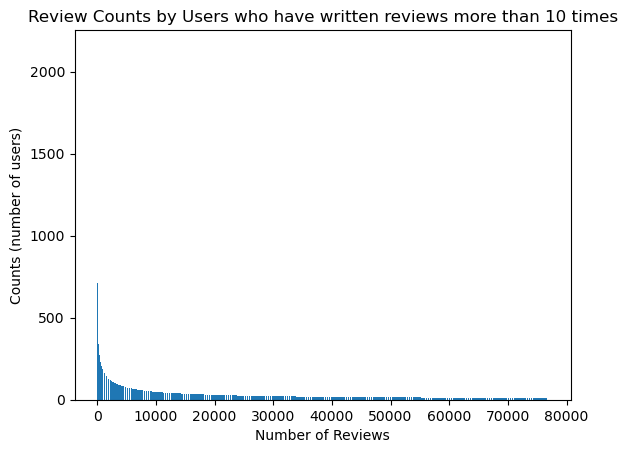

In [11]:
# group by user id in descending order
user_count = merge.groupby(by=["user_id"])['business_id'].count().sort_values(ascending=False)
# checking unique users
print(f"{len(user_count)} users have written the {merge.shape[0]} reviews on business in the dataset.")

# checking unique users with more than 10 reviews written
user_count = user_count.to_frame()
users_aboveten = user_count[user_count['business_id'] > 10]['business_id']
print(f"There are {users_aboveten.shape[0]} users who have written more than 10 reviews on businesses.")

# Plot the counts of reviews by users
plt.bar(np.arange(users_aboveten.shape[0]), users_aboveten);
plt.title('Review Counts by Users who have written reviews more than 10 times')
plt.xlabel('Number of Reviews')
plt.ylabel("Counts (number of users)")
plt.show()

There is an obvious imbalance in the review dataset. However, mitigating class imbalance in this dataset can be considered improper since the number of reviews could be an indicator for the business’s popularity. Based on this assumption, both under-sampling of restaurants with more reviews and over-sampling (e.g. SMOTE) of restaurants with less reviews are inappropriate. Due to this reason, the class imbalance has been preserved for the review dataset.

## Modeling

Recommender systems are essentially information filtering systems which leverage statistical and machine learning models to learn user data (e.g. their past behaviors) and predict their current interests and preferences. There are roughly three main approaches to build a recommender system:

1. **Collaborative filtering**: suggestions are based solely on the similarities among users, or, alternatively, among items. 
2. **Content-based filtering**: suggestions are based on additional information such as a description of the item and a profile of the user's preferences.
3. **Hybrid**: a combination of the previous two approaches. 

Note that the collaborative filtering techniques can also be divided into two categories: **memory-based** and **model-based**. A memory-based approach makes predictions based solely on *memory* of past records by finding similarities or neighborhoods in users or items. A method-based approach assumes an underlying model to make predictions. 

Additionally, collaborative filtering can be further broken down into two types: **user-based** and **item-based**. The user-based collaborative filtering approach is based on an assumption that some users tend to share the same preferences. It basically group users into clusters given the information on ratings a user gave out. On the other hand, the item-based collaborative filtering makes predictions based on similarities among items that the users have previously rated. 

### Baseline Model

For this project, we choose the memory based collaborative filtering method as our baseline model, since the collaborative filtering is well known for its simplicity and, yet, effectiveness. 
To create the baseline model, we will create a user-item matrix, in which the rows represent users and columns represent the items. From here, we can then make predictions after calculating similarities among items. To facilitate our implementation, we will rely on the recommendation system package [`scikit-surprise`](https://surpriselib.com/), particularly the `KNNWithMeans` method which takes into account the mean ratings of each user.

We will explore both user-based and item-based approaches and try out different similarity metrics such as Mean Squared Difference (MSD) and cosine similarity. Note that the MSD similarity can be computed as follows:

$$msd\_sim(u, v) = \frac{1}{msd(u, v) + 1} \text{ where } msd(u,v) = \frac{1}{|I_{uv}|} \cdot \sum_{i \in I_{uv}} (r_{ui} - r_{vi})^2, $$

$I_{uv}$ is the set of all items rated by both users $u$ and $v$, $r_{ui}$ the true rating of user $u$ for item $i$.

First, import the cleaned dataset with 3 columns: `user_id`, `business_id`,  and`stars` where  each row corresponds to a user's rating for a particular restaurant.

In [12]:
review_df = pd.read_feather('data/yelp_review_cleaned.feather')
df = review_df.loc[:, ['user_id', 'business_id', 'stars']]

Due to resource limitation, we will sample only 10K records for our model:

In [13]:
sub = df.sample(10000, random_state = 42)
sub.head()

,user_id,business_id,stars
1322294,0lpxU4Dfi8AeBt0SeCrEuw,tQKqrLs16Xi-lFrd3_CBAQ,1
4297632,5nw1Zc3fi_ehDJFd3mUEYA,nLxNJuvgoHQHn_IGYifRnw,1
2143059,7fDqaGdUMccXQ4bnPwR6yg,etaIhl-sduOKc6J_qHmmtA,3
3068250,GyFJNSJjI5aWww-D0Btcbw,GlKffg2PMtzByocI5OHIQA,3
1371839,o66iBwIWxfWPypnqfrHVNw,XVFUNtPWYpxhoWPtBQHFdQ,2


In [14]:
# load in data into scikit-surprise format
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(sub, reader)

# configs
sim_options = {
    "name": "cosine",  # to use item-based cosine similarity
    "user_based": False,  # Compute similarities between items
}

algo = KNNWithMeans(sim_options=sim_options)

trainingSet = data.build_full_trainset()
algo.fit(trainingSet)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [15]:
# predict some samples
prediction = algo.predict(sub.iloc[4, 0], sub.iloc[4, 1])
prediction.est

2.0

Here, we perform a hyperparameter grid search to optimize prediction errors:

In [16]:
sim_options = {
    "name": ["msd", "cosine"],
    "min_support": [3, 4, 5],
    "user_based": [False, True],
}

param_grid = {"sim_options": sim_options}

gs = GridSearchCV(KNNWithMeans, param_grid, measures=["rmse", "mse", "mae"], cv=3)
gs.fit(data)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

The best model has the MSE of 1.98 using the Mean Squared Difference similarity metric, minimum number of common items of 3, and user-based approach.

In [17]:
print(f'best rmse: {gs.best_score["mse"]}')
print(f'best params: {gs.best_params["mse"]}')

best rmse: 1.9810003243914922
best params: {'sim_options': {'name': 'msd', 'min_support': 3, 'user_based': False}}


It is important to note that this type of collaborative filtering may suffer from three problems: data sparsity, scalability, and cold start. Oftentimes, the data is sparse, meaning that a user has rates only a small number of restaurants while there are thousands of restaurants avaiable in the dataset. The use of a user-item matrix also makes it difficult to scale up as the size of the data increases. Most importantly, because this approach relies on past information, it suffers from cold start problem where it cannot predict given a new user or item due to the lack of prior information.

### Neural Collaborative Filtering (NCF) Model

The baseline model, which depends a 2-dimensional user-item interaction matrix, works by simply calculating similarity scores using a certain similarity metric and recommends items or restaurants based on these similarities. Now, we will create a more robust model by perfoming the following:

- Extend the 2D user-item matrix into a four-dimensional tensor by attaching user features as well as item/restaurant features. 
- Train the model using a neural network architecture.

This method is known as the **neural collaborative filtering (NCF)** approach. He et al. (2017) empirically shows that using deeper layers of neural networks provides better recommendation performance. 

We will now load in datasets from all necessary sources: users, restaurants, and reviews:

In [18]:
%%time
user_df = pd.read_feather('data/yelp_user_cleaned.feather')  # 100 MB
business_df = pd.read_feather('data/yelp_business_cleaned.feather')  # 40 MB
review_df = pd.read_feather('data/yelp_review_cleaned.feather')  # 2.3 GB

CPU times: user 5.8 s, sys: 8.42 s, total: 14.2 s
Wall time: 38.9 s


In [19]:
user_df.user_id.unique().shape, review_df.user_id.unique().shape

((1532223,), (1532233,))

In [20]:
business_df.business_id.unique().shape, review_df.business_id.unique().shape

((68054,), (68054,))

Due to resource limitation, we sample 100K review records for model training.

In [21]:
review_df = review_df.sample(100_000, random_state=42)

We use the review dataset to build our user-item matrix. Note that previously we only kept these columns for building user-item matrix: `['user_id', 'business_id', 'stars']`, but for the NCF model we include additional features from review data: `['useful', 'funny', 'cool']`.

In [22]:
review_df = review_df.loc[:, ['user_id', 'business_id', 'stars', 'useful', 'funny', 'cool', 'text']]
review_df.head(3)

,user_id,business_id,stars,useful,funny,cool,text
1322294,0lpxU4Dfi8AeBt0SeCrEuw,tQKqrLs16Xi-lFrd3_CBAQ,1,2,0,0,My friends and I went there on a Friday night ...
4297632,5nw1Zc3fi_ehDJFd3mUEYA,nLxNJuvgoHQHn_IGYifRnw,1,1,0,0,"Clean, friendly waitstaff. The food, well, to..."
2143059,7fDqaGdUMccXQ4bnPwR6yg,etaIhl-sduOKc6J_qHmmtA,3,2,0,2,"Super swanky lunch spot in Clayton. I love, l..."


In [23]:
user_df.drop(['name'], axis=1, inplace=True)

In [24]:
# why we rename it here and not use the suffixes for merging:
# we will later need to know which features are related to users
# keep a list of column names here is more convenient
user_df.rename({'useful': 'useful_user',
                'funny': 'funny_user',
                'cool': 'cool_user',
                'review_count': 'review_count_user'}, axis=1, inplace=True)

In [25]:
# note: we've already expanded the dictionaries such as attributes in business_data_inspect.ipynb
business_df.drop(['original_index', 'name', 'address', 'city', 'state',
                  'postal_code', 'latitude', 'longitude',
                  'attributes', 'categories', 'is_restaurant', 'GoodForMeal', 'BestNights'], axis=1, inplace=True)

In [26]:
business_df.rename({'stars': 'stars_business',
                    'review_count': 'review_count_business'}, axis=1, inplace=True)

One-hot encode categorical features (except IDs) in the business dataset, and merge all three dataframes together:

In [27]:
dummies = pd.get_dummies(business_df.drop('business_id', axis=1), drop_first=True)
business_df = pd.concat([business_df.loc[:, ['business_id']], dummies], axis=1)

In [29]:
df = pd.merge(review_df, user_df, on='user_id')
df = pd.merge(df, business_df, on='business_id')

For this part, we exclude the review text from our model training. We will include it back in for our model extension below:

In [31]:
df.drop('text', axis=1, inplace=True)

Again, we sample 10K records due to resource limitation:

In [33]:
df = df.sample(10_000, random_state=42).reset_index(drop=True)
df.shape

(10000, 7470)

Filter out unneeded rows in `user_df`, `business_df`, and `review_df` to match `df`:

In [34]:
user_df = user_df.loc[user_df['user_id'].isin(df['user_id']), :].copy().reset_index(drop=True)
business_df = business_df.loc[business_df['business_id'].isin(df['business_id']), :].copy().reset_index(drop=True)
review_df = review_df.loc[(review_df['user_id'].isin(df['user_id'])) & \
                    (review_df['business_id'].isin(df['business_id'])), :].copy().reset_index(drop=True)

As mentioned above, we remove `text` from `review_df` for now, but save it for the later extension.

In [35]:
review_text = review_df['text'].copy()
review_df.drop('text', axis=1, inplace=True)

Before model training, we have to encode `user_id` and `business_id` to convert string into integers:

In [37]:
user_id_encoder = LabelEncoder()
business_id_encoder = LabelEncoder()

user_df['user_id'] = user_id_encoder.fit_transform(user_df['user_id'])
review_df['user_id'] = user_id_encoder.transform(review_df['user_id'])
business_df['business_id'] = business_id_encoder.fit_transform(business_df['business_id'])
review_df['business_id'] = business_id_encoder.transform(review_df['business_id'])

df['user_id'] = user_id_encoder.transform(df['user_id'])
df['business_id'] = business_id_encoder.transform(df['business_id'])

We split train and test sets with the test size of 20% and scale the numerical features:

In [38]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [39]:
def feature_scaling(df_train, df_test):
    # save stars (target, do not scale)
    stars_train = df_train['stars'].copy()
    stars_test = df_test['stars'].copy()

    # scale features
    scaler = MinMaxScaler()
    df_train = scaler.fit_transform(df_train)
    df_test = scaler.transform(df_test)

    # convert back to data frames
    df_train = pd.DataFrame(df_train, columns=df.columns)
    df_test = pd.DataFrame(df_test, columns=df.columns)

    # restore stars
    df_train['stars'] = stars_train.values
    df_test['stars'] = stars_test.values

    return df_train, df_test

In [40]:
df_train, df_test = feature_scaling(df_train, df_test)

We build a neural network model following the architecture drawn below in Figure 2:

<figure>
<figcaption><strong>Figure 2</strong></figcaption>
<img src="Figures/model_architecture.png"  width="700">
</figure>

In [41]:
def build_model(df=df, user_df=user_df, business_df=business_df):
    # helper constants
    num_users = df['user_id'].nunique()
    num_businesses = df['business_id'].nunique()
    
    # Model architecture:
    
    # embeddings for id's
    user_input = Input(shape=(1,), name='user_input')
    user_embedding = Embedding(num_users, 16, name='user_embedding')(user_input)
    user_flatten = Flatten(name='user_flatten')(user_embedding)

    business_input = Input(shape=(1,), name='business_input')
    business_embedding = Embedding(num_businesses, 16, name='business_embedding')(business_input)
    business_flatten = Flatten(name='business_flatten')(business_embedding)

    dot_product = Dot(axes=1, name='dot_product')([user_flatten, business_flatten])

    # add in user and business features
    user_features_input = Input(shape=(user_df.shape[1] - 1,), name='user_features_input')
    business_features_input = Input(shape=(business_df.shape[1] - 1,), name='business_features_input')
    concat_features = Concatenate(name='concat_features')([dot_product, user_features_input, business_features_input])

    dense_layer = Dense(64, activation='relu', name='dense_layer')(concat_features)
    output = Dense(1, activation='linear', name='output')(dense_layer)

    model = Model(inputs=[user_input, business_input, user_features_input, business_features_input], outputs=output)
    model.compile(optimizer=Adam(0.0001), loss='mean_squared_error')
    
    return model

In [42]:
model = build_model()

Train the model using 15 epochs and validation split of size 10%.

In [43]:
def train_model(model, df_train=df_train, user_df=user_df, business_df=business_df):
    train_inputs = [
        df_train['user_id'].values,
        df_train['business_id'].values,
        df_train[user_df.columns[1:]].values,
        df_train[business_df.columns[1:]].values
    ]

    model.fit(train_inputs, df_train['stars'].values, epochs=15, validation_split=0.1)

In [44]:
%%time
train_model(model)

Epoch 1/15


2023-05-07 02:56:18.139251: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


225/225 [==============================] - 4s 17ms/step - loss: 4.9440 - val_loss: 2.0735
Epoch 2/15
225/225 [==============================] - 1s 3ms/step - loss: 1.9362 - val_loss: 1.9881
Epoch 3/15
225/225 [==============================] - 1s 3ms/step - loss: 1.8497 - val_loss: 1.9161
Epoch 4/15
225/225 [==============================] - 1s 2ms/step - loss: 1.7765 - val_loss: 1.8627
Epoch 5/15
225/225 [==============================] - 1s 3ms/step - loss: 1.7116 - val_loss: 1.7947
Epoch 6/15
225/225 [==============================] - 1s 3ms/step - loss: 1.6506 - val_loss: 1.7503
Epoch 7/15
225/225 [==============================] - 1s 3ms/step - loss: 1.5941 - val_loss: 1.7067
Epoch 8/15
225/225 [==============================] - 1s 3ms/step - loss: 1.5420 - val_loss: 1.6788
Epoch 9/15
225/225 [==============================] - 1s 4ms/step - loss: 1.4918 - val_loss: 1.6359
Epoch 10/15
225/225 [==============================] - 1s 4ms/step - loss: 1.4483 - val_loss: 1.6079
Epoch 11/

We evaluate our model on the test set and get a mean square error of 1.404, or equivalently RMSE of 1.185. Recall that our baseline model has RMSE of 1.409. Thus, the neural collaborative filtering approach with the additional user and restaurant features clearly improves the performance of a recommender system.

In [45]:
def test_model(model, df_test=df_test, user_df=user_df, business_df=business_df):
    test_inputs = [
        df_test['user_id'].values,
        df_test['business_id'].values,
        df_test[user_df.columns[1:]].values,
        df_test[business_df.columns[1:]].values
    ]

    test_loss = model.evaluate(test_inputs, df_test['stars'].values)
    print(f'Test loss (MSE): {round(test_loss, 3)}')

In [46]:
test_model(model)

63/63 [==============================] - 0s 738us/step - loss: 1.4037
Test loss (MSE): 1.404


#### Model Extension 1: Cluster Labels

We would like to improve the performance of our model even further by adding in new features to the training set. In this section, we will perform clustering on users and businesses. The cluster labels will be used as an additional feature. Note that this method is called a mixed cluster network.

First, we prepare our data for this model by scaling `user_df`:

In [47]:
def scale(df):
    scaler = MinMaxScaler()
    return scaler.fit_transform(df)

In [48]:
user_df_scaled = scale(user_df)

And apply dimensionality reduction using PCA of 10 components:

In [49]:
def pca(df_scaled):
    pca = PCA(n_components=10)
    return pca.fit_transform(df_scaled)

In [50]:
user_df_pca = pca(user_df_scaled)

We also user DBSCAN and apply hyperparameter tuning on epsilons and the minimum number of samples to find one with the best (highest) silhouette score:

In [51]:
def tune_clusterer(df_pca):
    best_score = -1

    for eps in np.arange(0.1, 2, 0.1):
        for min_samples in range(2, 3):
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(df_pca)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            if n_clusters > 1:
                score = silhouette_score(df_pca, labels)
                if score > best_score:
                    best_score = score
                    best_eps = eps
                    best_min_samples = min_samples

    print("Best Silhouette Score:", best_score)
    print("Best eps:", best_eps)
    print("Best min_samples:", best_min_samples)
    
    return best_eps, best_min_samples

In [52]:
%%time
best_eps, best_min_samples = tune_clusterer(user_df_pca)

Best Silhouette Score: 0.5545330937146584
Best eps: 0.30000000000000004
Best min_samples: 2
CPU times: user 18.2 s, sys: 5.87 s, total: 24 s
Wall time: 23.9 s


Get cluster label using the tuned hyperparameters above:

In [53]:
def generate_clusters(df_pca, best_eps, best_min_samples):
    dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
    labels = dbscan.fit_predict(df_pca)
    return labels

In [54]:
user_df['user_clusters'] = generate_clusters(user_df_pca, best_eps, best_min_samples)
np.unique(user_df['user_clusters'])

array([-1,  0,  1])

Evaluation:

In [55]:
print(f"Silhouette Score: {silhouette_score(user_df_pca, user_df['user_clusters'])}")

Silhouette Score: 0.5545330937146584


Perform the same procedures for `business_df`:

In [56]:
%%time
business_df_scaled = scale(business_df)
business_df_pca = pca(business_df_scaled)
best_eps, best_min_samples = tune_clusterer(business_df_pca)
business_df['business_clusters'] = generate_clusters(business_df_pca, best_eps, best_min_samples)
print(f"Silhouette Score: {silhouette_score(business_df_pca, business_df['business_clusters'])}")

Best Silhouette Score: 0.11581093584722416
Best eps: 1.9000000000000001
Best min_samples: 2
Silhouette Score: 0.11581093584722416
CPU times: user 26.1 s, sys: 4.05 s, total: 30.2 s
Wall time: 16.5 s


#### Model Extension 2: Sentiment Labels

Like the first extension we added, we will now perform sentiment analysis on review text and use the sentiment labels as another feature into the NCF model. We thought about using transfer learning on BERT to fine tune our own sentiment analysis model; however, transfer learning requires labeled data (the ground truth sentiment labels), which we do not have. So instaed, we will be using a pre-trained model. Note that transformers are really slow, so we will be using the Python library named `TextBlob` which is faster.

In [57]:
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

In [58]:
%%time
review_df['review_sentiment'] = review_text.apply(get_sentiment)

CPU times: user 3.64 s, sys: 68.3 ms, total: 3.71 s
Wall time: 3.77 s


In [59]:
review_df['review_sentiment'].head()

0    0.535714
1    0.159977
2    0.733333
3   -0.551515
4    0.097064
Name: review_sentiment, dtype: float64

In [60]:
review_df['review_sentiment'].describe()

count    11946.000000
mean         0.260394
std          0.230792
min         -1.000000
25%          0.130695
50%          0.264103
75%          0.398842
max          1.000000
Name: review_sentiment, dtype: float64

#### NCF Model with the Two Extensions: Cluster and Sentiment Labels

In [61]:
df = pd.merge(review_df, user_df, on='user_id')
df = pd.merge(df, business_df, on='business_id')

In [62]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [63]:
df_train, df_test = feature_scaling(df_train, df_test)

In [64]:
model = build_model(df=df, user_df=user_df, business_df=business_df)

In [65]:
%%time
train_model(model, df_train=df_train, user_df=user_df, business_df=business_df)

Epoch 1/15
269/269 [==============================] - 1s 3ms/step - loss: 4.2128 - val_loss: 1.9148
Epoch 2/15
269/269 [==============================] - 1s 2ms/step - loss: 1.7431 - val_loss: 1.8390
Epoch 3/15
269/269 [==============================] - 1s 3ms/step - loss: 1.6692 - val_loss: 1.7998
Epoch 4/15
269/269 [==============================] - 1s 3ms/step - loss: 1.6097 - val_loss: 1.7651
Epoch 5/15
269/269 [==============================] - 1s 3ms/step - loss: 1.5537 - val_loss: 1.7360
Epoch 6/15
269/269 [==============================] - 1s 3ms/step - loss: 1.5043 - val_loss: 1.7086
Epoch 7/15
269/269 [==============================] - 1s 3ms/step - loss: 1.4576 - val_loss: 1.6836
Epoch 8/15
269/269 [==============================] - 1s 3ms/step - loss: 1.4108 - val_loss: 1.6561
Epoch 9/15
269/269 [==============================] - 1s 3ms/step - loss: 1.3663 - val_loss: 1.6374
Epoch 10/15
269/269 [==============================] - 1s 3ms/step - loss: 1.3186 - val_loss: 1.6051

In [66]:
test_model(model, df_test=df_test, user_df=user_df, business_df=business_df)

75/75 [==============================] - 0s 708us/step - loss: 1.3760
Test loss (MSE): 1.376


This NCF model with the extensions performs slightly better than the NCF model without the extensions (RMSE 1.173 versus 1.185).

## Conclusion and Future Work

In this project, we explore a neural collaborative filtering (NCF) approach to build a restaurant recommender system. We create two NCF models, one with and another without the extended cluster and sentiment labels. Both incorporate additional features associated with users and restaurants. We compare our two models to a baseline model using a standard user-based collaborative filtering approach. The results show that the NCF models lead to an over 17% decrease in the test root mean squared error. (The full test results are shown in Table 1 below.) This is likely because, unlike the standard approach which suffers from sparse data, the neural network architecture can incorporate additional features on users and items and is able to learn individual preferences among the users.

However, there are multiple areas of possible improvement. First, an extensive finetuning process on the NCF network can be further made. Additionally, we would like to finetune and explore other approaches for clustering and sentiment analysis tasks, such as KMeans clustering. Moreover, this work has been focused solely on collaborative filtering, and in the future, we would like to compare our NCF models with the content-based, or hybrid, filtering approaches. 

**Table 1**:
| Model | Test RMSE |
|:----:|:-----:|
| Baseline | 1.409 |
| NCF | 1.185 |
| NCF with Extended Fetures | 1.173 |

In [67]:
t1 = datetime.now()
print(f'Time elapsed running notebook: {t1 - t0}')

Time elapsed running notebook: 0:07:20.770069
